## Investing factors influencing route choice from Connected Car Data

                                            Exploring Geogrpahic Variation

In [1]:
#Scikit Mobility Library
#import skmob
#from skmob import preprocessing
#from skmob.preprocessing import detection, clustering
#from skmob.preprocessing import compression

#Datashader Library
#import datashader as ds, pandas as pd, colorcet as cc
# from datashader import transfer_functions as tf
# from datashader.colors import Hot
# from datashader.utils import export_image

#Dask & Flask_sqlalchemy libraries
# import dask
# import sqlalchemy


#Other ancillary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn; seaborn.set()
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import patheffects
plt.style.use('ggplot')
import geopandas as gpd
import pyarrow
#import pyodbc
#import webbrowser
import glob
import os
import osmnx as ox
from shapely.geometry import LineString, Point


import warnings
warnings.filterwarnings('ignore')

Reading In Data

In [1]:
uk1 = pd.read_parquet(r"N:\Code Routing Behaviour\Ukmaindata1.parquet")
uk1.tail()

### Filetering Dataframe

##### Equal Number of Days represented in dataframe. 

Selecting values based on date from 4th July to 30th July that way we have an equal number of represented days to analyse.

In [3]:
mask = (uk1['datetime'] >= '2022-07-04') & (uk1['datetime'] < '2022-08-01')

In [4]:
df = uk1[mask]

##### Filetering Out Oneway Trips

Round trips distort Sinuosity values

In [5]:
Main = df.loc[df["shortestPath_dist"]>=0.8].copy()

In [6]:
Main['weekday'] = (Main['datetime']).dt.day_name()

In [7]:
Main['hour']= Main['datetime'].apply(lambda x: str(x.hour).zfill(2)+':00').copy()



## Exploring Geographic Variation

In [8]:
trajgeog = Main.reset_index()

In [9]:
origplot = trajgeog[['tid','origin','distance_straight_line','StopTime','num_of_turns','sinuosity','hour','weekday']].copy()

##### Extract orgin lats and lngs from dataset

In [13]:
%%time
origplot[['lat','lng']] = origplot['origin'].apply(lambda x: pd.Series(x))

CPU times: total: 2min 13s
Wall time: 2min 14s


In [14]:
%%time
origplot.drop('origin', axis=1, inplace=True)
origplot.to_csv("origplot.csv")

CPU times: total: 10.5 s
Wall time: 1min 48s


#### Read in Shapefile

In [3]:
%%time
shape_file = gpd.read_file(r"N:\_incoming\2023-01-25\Local_Authority_Districts_(December_2022)_Boundaries_UK_BFE\LAD_DEC_2022_UK_BFE.shp")

CPU times: total: 1.3 s
Wall time: 1.87 s


##### Read in origin data

In [4]:
%%time
points = gpd.read_file("N:\Code Routing Behaviour\Mapping\origreprojectedplot.geojson")

CPU times: total: 2min 28s
Wall time: 2min 29s


##### Join reprojected points to shapefile

In [2]:
%%time
PJoin = shape_file.sjoin(points, how='left').drop('index_right', axis=1)
PJoin.head(2)

CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
phexpoint = PJoin[['LAD22CD','LAD22NM','tid','distance_straight_line','StopTime','num_of_turns','sinuosity','hour','weekday','lat','lng']]
phexpoint

## Visualising Origin Counts by Local Authority Districts

                                   Visualising using uk cartograms-noncontiguous

###### Map - Groups are scaled in size relative to their population using hexagons, separated and then arranged according to their relative geographic position

##### Reading in Shape files 

In [7]:
%%time
hex_file = gpd.read_file(r"N:\Code Routing Behaviour\Mapping\hex_layer.geojson")

CPU times: total: 203 ms
Wall time: 324 ms


In [8]:
%%time
hex_backlayer = gpd.read_file(r"N:\Code Routing Behaviour\Mapping\hex_backgroud.geojson")

CPU times: total: 31.2 ms
Wall time: 82 ms


In [9]:
%%time
hex_G2 = gpd.read_file(r"N:\Code Routing Behaviour\Mapping\Group2.geojson")

CPU times: total: 93.8 ms
Wall time: 179 ms


In [10]:
Hex = hex_file.rename(columns={'Lacode':'LAD22CD'})

##### Merging points to shapefile

Here I use the dataset below to figure out what I want to visualise 

In [13]:
PJoinhex = Hex.merge(phexpoint,on='LAD22CD', how='left')

##### Visualising Trip count by Local Authority District

In [14]:
%%time
Lacount = PJoinhex.groupby('LAD22CD')['tid'].count()
Lacount.reset_index(name='Tid_Count').head()

CPU times: total: 109 ms
Wall time: 92 ms


LAD22CD  Tid_Count
0  E06000001       3645
1  E06000002       3071
2  E06000003       2378
3  E06000004       5326
4  E06000005       3132

In [4]:
%%time
Tcount = PJoinhex.merge(Lacount, on='LAD22CD', how='left')
Counthex = Tcount.rename(columns={'tid_y':'Tid_Count'})
Counthex1 = Counthex.drop_duplicates(subset=['LAD22CD','Tid_Count'])
Counthex1

CPU times: total: 0 ns
Wall time: 0 ns


##### Plotting Visualisation 

                                         Trip Start counts by LA District

CPU times: total: 1.89 s
Wall time: 2.05 s


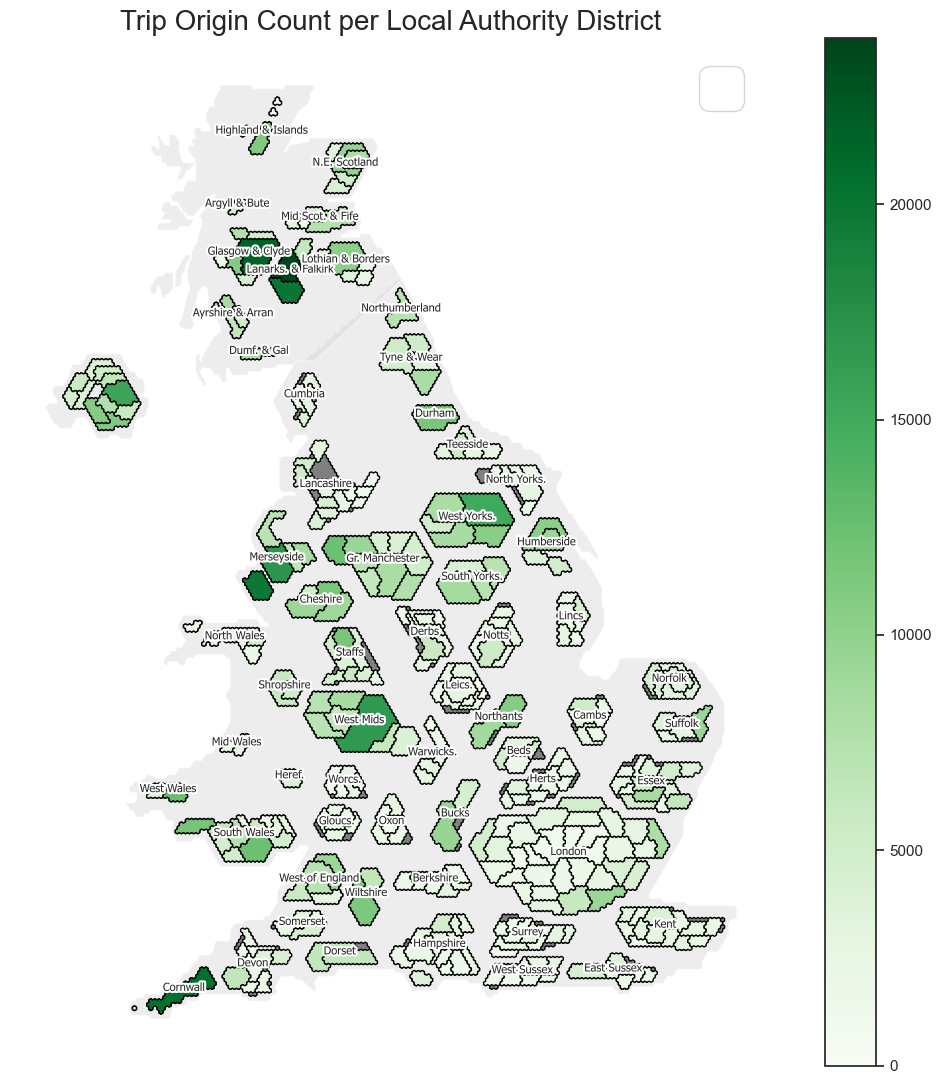

In [149]:
%%time
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
           label='Group',
           color='grey',
           edgecolor='black')

Counthex1.plot(column='Tid_Count',
            cmap='Greens',
            legend=True,
            ax = ax,
            edgecolor='black',
            alpha=1.0)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)

plt.title('Trip Origin Count per Local Authority District', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(['tid'], fontsize=40)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Maps\Map_Tripcount_LA2.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

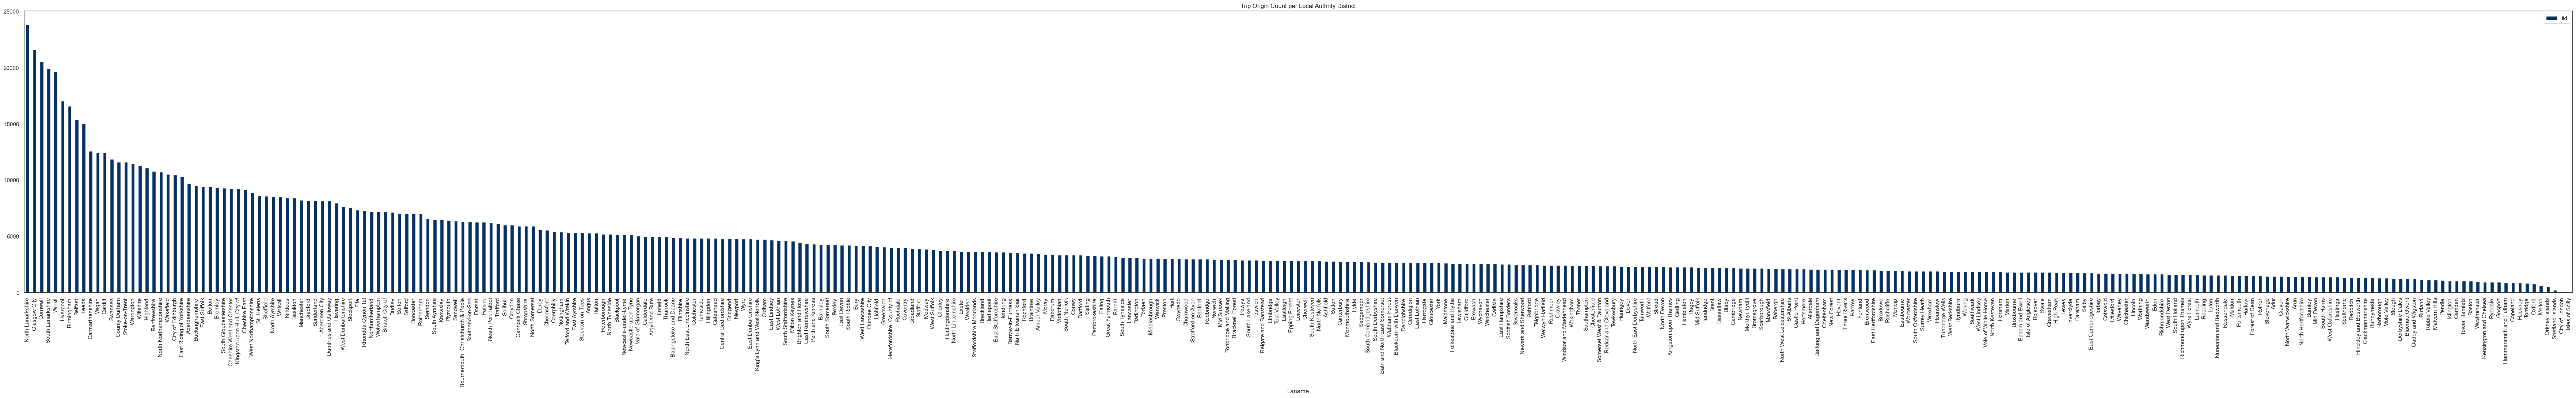

In [70]:
ordplot = PJoinhex.groupby(by=['Laname','Group','Group-labe'])['tid'].count().sort_values(ascending=False)
ordplot.reset_index().plot(kind='bar', x='Laname', y='tid', cmap='RdBu_r',figsize=(90,10))
plt.title('Trip Origin Count per Local Authrity District')
plt.show()

In [142]:
valuect = ordplot.reset_index().groupby('Group').sum().sort_values(by=['tid'],ascending=False)
valuect.head(10)

tid
Group                       
London                 89740
Greater Manchester     68738
South Wales            67231
Merseyside             58924
West Midlands          55893
Essex                  52557
Glasgow & Clyde        51067
Lanarkshire & Falkirk  50079
West Yorkshire         47305
Staffordshire          44956

##### Visualising Averge Distance travelled by Local Authority District

In [139]:
%%time
Ladistmean = PJoinhex.groupby(by=['LAD22CD','Laname','Group'])['distance_straight_line'].mean()
Ladistmean .reset_index(name='Mean_Dist_travelled').sort_values(by =['Mean_Dist_travelled'], ascending=False)

CPU times: total: 453 ms
Wall time: 455 ms


LAD22CD             Laname               Group  Mean_Dist_travelled
68   E07000030               Eden             Cumbria            45.607406
34   E06000037     West Berkshire           Berkshire            33.690292
102  E07000077         Uttlesford               Essex            25.889004
276  E09000001     City of London              London            23.842422
107  E07000082             Stroud     Gloucestershire            22.331022
..         ...                ...                 ...                  ...
43   E06000046      Isle of Wight       Isle of Wight             6.684045
254  E08000015             Wirral          Merseyside             6.542876
332  S12000023     Orkney Islands  Highland & Islands             6.052994
65   E07000027  Barrow-in-Furness             Cumbria             5.043287
49   E06000053    Isles of Scilly            Cornwall                  NaN

[374 rows x 4 columns]

In [5]:
distLa = PJoinhex.merge(Ladistmean, on='LAD22CD', how='left')
#turnhex = TurnLa.rename(columns={'num_of_turns_y':'Avg_turns'})
distLa1 = distLa.drop_duplicates(subset=['LAD22CD','distance_straight_line_y'])
distLa1.head()

CPU times: total: 1.81 s
Wall time: 2.04 s


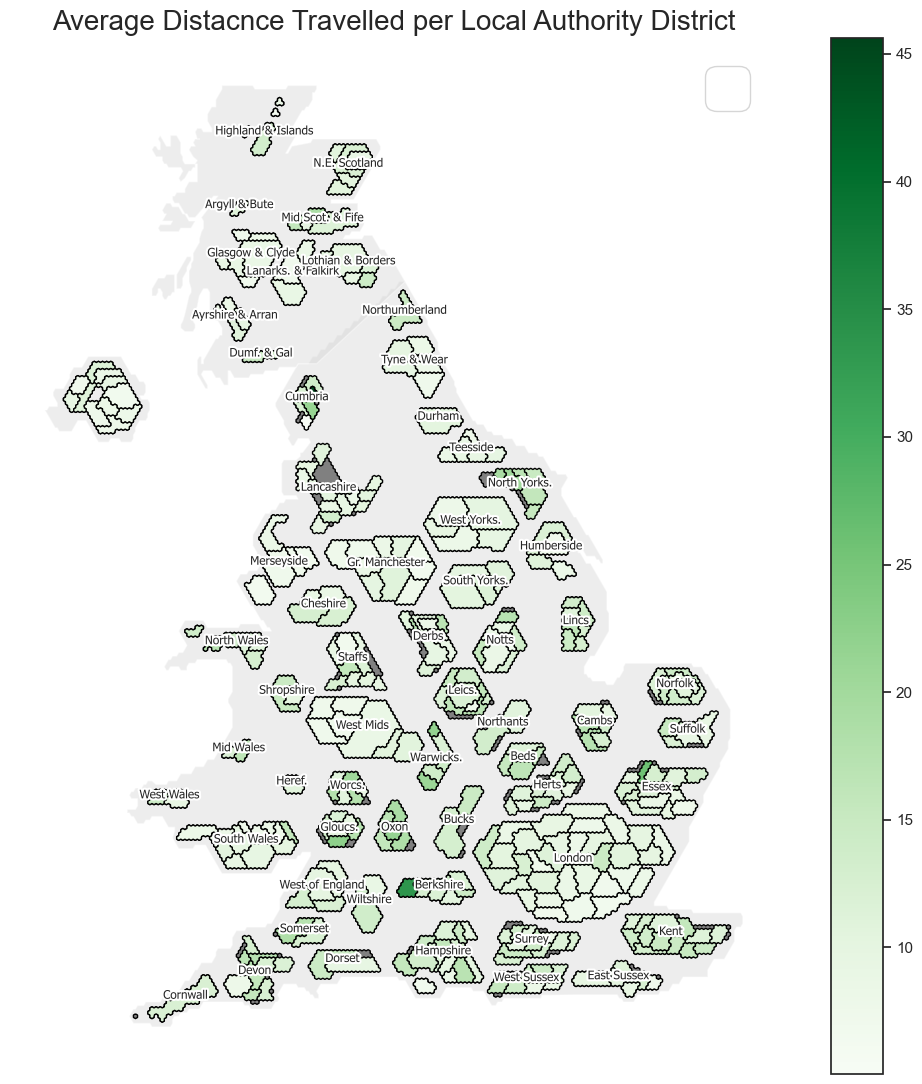

In [153]:
%%time
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)

hex_G2.plot(ax=ax,
            label='Group',
            edgecolor='black',
            color='grey')

distLa1.plot(column='distance_straight_line_y',
            cmap='Greens',
            legend=True,
            ax = ax,
            edgecolor='black',
            alpha=1)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)

plt.title('Average Distacnce Travelled per Local Authority District', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(['num_of_turns_y'], fontsize=40)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Maps\Map_Avg dist travelled.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

##### Visualising Number of turns by Local Authority District

In [157]:
Laturn = PJoinhex.groupby(by=['LAD22CD','Laname','Group','Group-labe'])['num_of_turns'].mean()
Tt = Laturn.reset_index(name='Avg_turns')
Tt.groupby('Group').mean().sort_values(by=['Avg_turns'],ascending=False)

Avg_turns
Group                              
London                    24.179596
Bedfordshire              17.967785
Berkshire                 17.199357
West of England           16.811251
West Sussex               16.690981
Surrey                    16.587258
West Midlands             16.426032
Greater Manchester        16.332157
East Sussex               16.220549
Hertfordshire             16.218065
Essex                     15.953964
West Yorkshire            15.905412
Kent                      15.847348
South Yorkshire           15.843918
Wiltshire                 15.738621
Oxfordshire               15.697501
Buckinghamshire           15.594548
Cheshire                  15.441147
Warwickshire              15.437824
Hampshire                 15.385502
Derbyshire                15.054397
Merseyside                15.023767
Tyne and Wear             14.990251
Northamptonshire          14.927480
Nottinghamshire           14.874246
Leicestershire & Rutland  14.862499
Worcestershire            14.785038
Devon                     14.784634
Dorset                    14.628080
South Wales               14.601193
Northern Ireland          14.516620
Glasgow & Clyde           14.383328
Lancashire                14.378957
Staffordshire             14.002323
Lanarkshire & Falkirk     13.979132
North Yorkshire           13.957294
Lothian & Borders         13.948557
Teesside                  13.822504
Somerset                  13.781488
Gloucestershire           13.708494
Humberside                13.654549
Herefordshire             13.634972
Shropshire                13.577971
Suffolk                   13.474525
Lincolnshire              13.462022
Cambridgeshire            13.452416
County Durham             13.432123
Ayrshire & Arran          13.422975
Cornwall                  13.402618
Cumbria                   13.289979
Norfolk                   13.237393
Northumberland            13.138508
Mid Scotland & Fife       12.666989
North East Scotland       12.635991
West Wales                12.061551
Mid Wales                 11.324723
Dumfries & Galloway       11.244297
North Wales               11.003822
Argyll & Bute              9.976633
Highland & Islands         9.118674

In [6]:
TurnLa = PJoinhex.merge(Laturn, on='LAD22CD', how='left')
#turnhex = TurnLa.rename(columns={'num_of_turns_y':'Avg_turns'})
TurnLa1 = TurnLa.drop_duplicates(subset=['LAD22CD','num_of_turns_y'])
TurnLa1.head()

##### Plotting Visualisation 

                                       Average number of turns by LA District

CPU times: total: 1.97 s
Wall time: 2.13 s


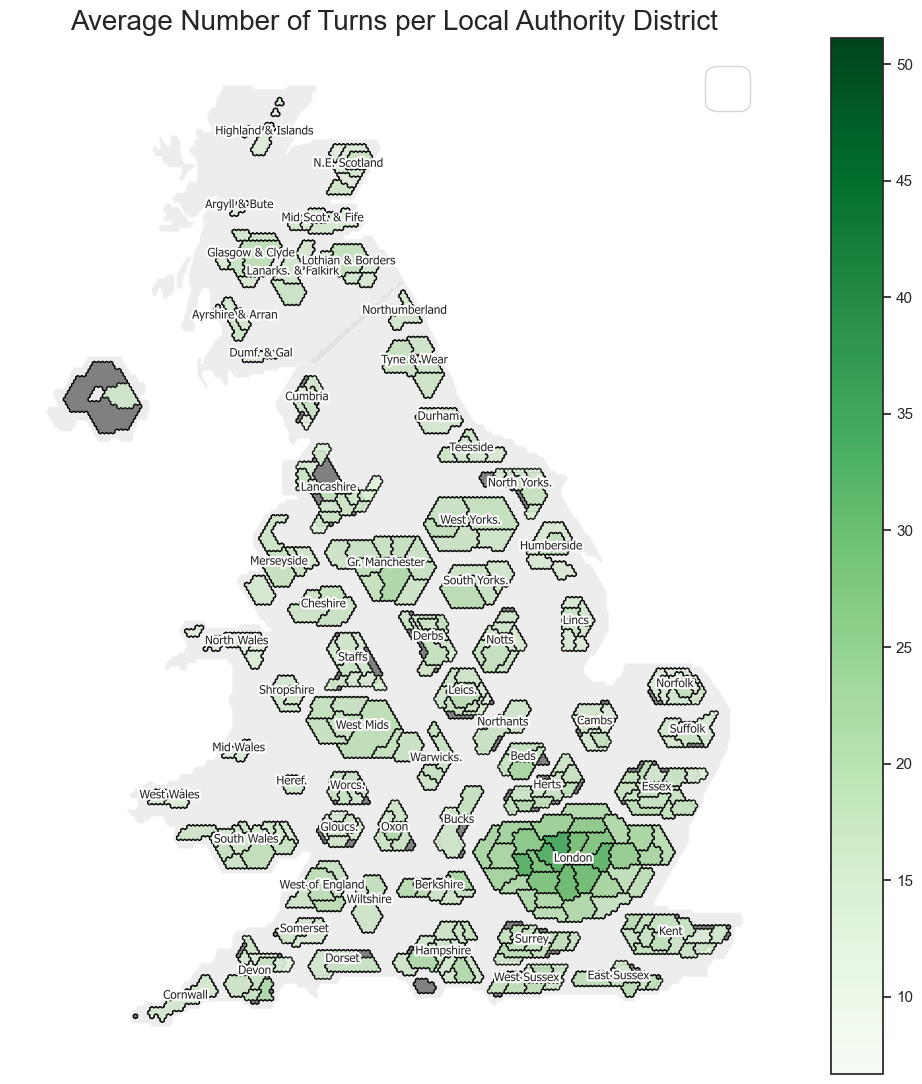

In [159]:
%%time
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)

hex_G2.plot(ax=ax,
            label='Group',
            color='grey',
            edgecolor='black')

TurnLa1.plot(column='num_of_turns_y',
            cmap='Greens',
            legend=True,
            ax = ax,
            edgecolor='black',
            alpha=0.9)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)

plt.title('Average Number of Turns per Local Authority District', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(['num_of_turns_y'], fontsize=40)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Maps\Map_Avg num of turns.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

##### Visualising Sinuosity by Local Authority District

In [75]:
Lasinu = PJoinhex.groupby('LAD22CD')['sinuosity'].mean()
Lasinu.reset_index(name='Asinuosity').head()

LAD22CD  Asinuosity
0  E06000001    2.060400
1  E06000002    2.551685
2  E06000003    2.321714
3  E06000004    2.529403
4  E06000005    1.956650

In [161]:
sinuLa = PJoinhex.merge(Lasinu, on='LAD22CD', how='left')
sinuhex = sinuLa.rename(columns={'sinuosity_y':'Avg_sinuosity'})
sinuhex1 = sinuhex.drop_duplicates(subset=['LAD22CD', 'Avg_sinuosity'])

##### Plotting Visualisation 

                                           Average Sinuosity by LA District

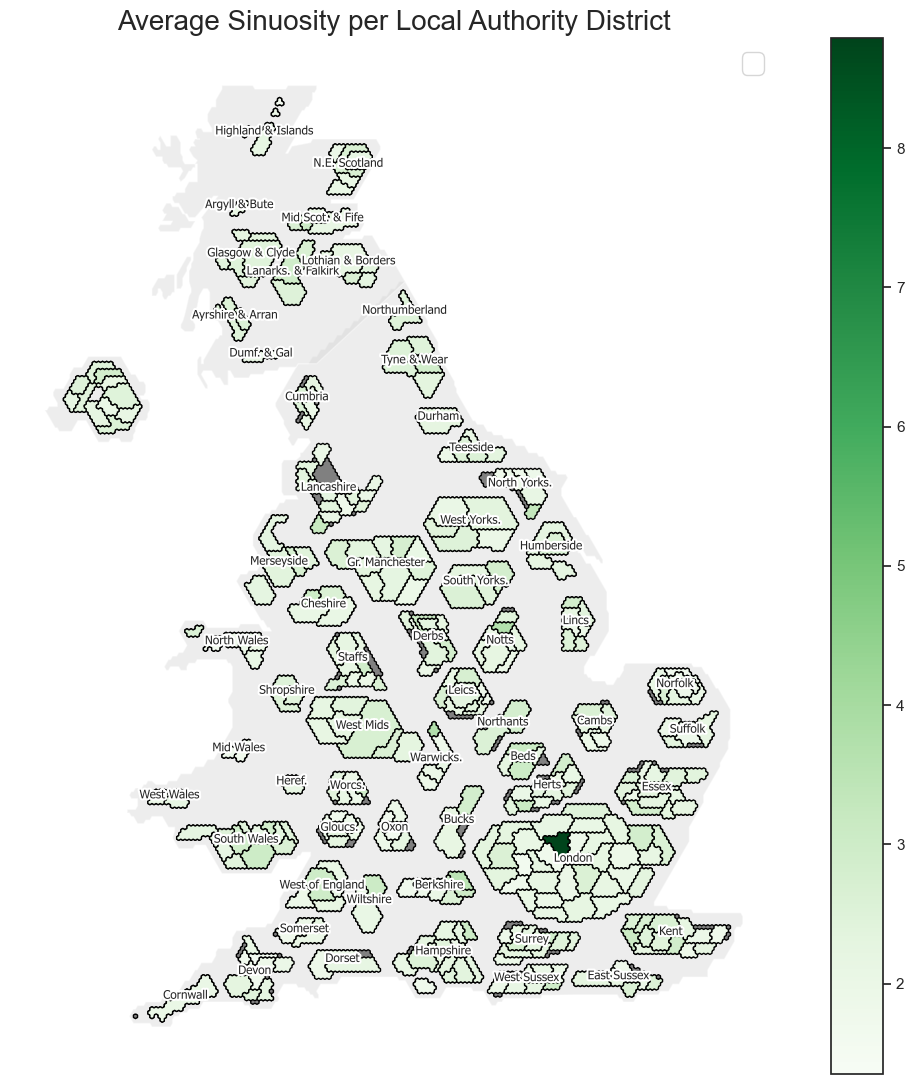

In [199]:
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
            color='grey',
            edgecolor='black')

sinuhex1.plot(column='Avg_sinuosity',
            cmap='Greens',
            legend=True,
            ax = ax,
            edgecolor='black',
            alpha=1)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)

plt.title('Average Sinuosity per Local Authority District', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(['Avg_sinuosity'], fontsize=20)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Maps\Map_Sinuosity_LA.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

                            Number of Clusters choosen to be used for this Exercise -  4. 

##### Visualising Rural Urban Classification by Local Authority District

In [185]:
%%time
Urb_ru = pd.read_csv(r"N:\Code Routing Behaviour\Mapping\Urban_rural_LA.csv")
Urb_ru1 = Urb_ru.rename(columns={'Local Authority District Area 2021 Code':'LAD22CD'})

CPU times: total: 15.6 ms
Wall time: 131 ms


In [206]:
UrbRu = PJoinhex.merge(Urb_ru1, on='LAD22CD', how='left')
UrbRu2 = UrbRu.drop_duplicates(subset=['LAD22CD', 'Rural Urban Classification 2011 (3 fold)']).drop('Unnamed: 4', axis=1)
UrbRu2

fid    LAD22CD                  Laname LA-label  \
0          1  E07000071              Colchester     Col.   
4852       2  E09000009                  Ealing     None   
8107       3  E07000124           Ribble Valley     None   
9255       4  E06000020      Telford and Wrekin    Telf.   
14599      5  E07000083              Tewkesbury     None   
...      ...        ...                     ...      ...   
1535076  370  E07000133                  Melton     None   
1535712  371  E07000132   Hinckley and Bosworth     None   
1537077  372  E07000131              Harborough     None   
1538390  373  E06000062   West Northamptonshire     None   
1547296  374  E06000061  North Northamptonshire     None   

                            Group     Group-labe     RegionNation    cuacode  \
0                           Essex          Essex  East of England  E10000012   
4852                       London         London           London  E09000009   
8107                   Lancashire     Lancashire       North West  E10000017   
9255                   Shropshire     Shropshire    West Midlands  E06000020   
14599             Gloucestershire        Gloucs.       South West  E10000013   
...                           ...            ...              ...        ...   
1535076  Leicestershire & Rutland  Leics. & Rut.    East Midlands  E10000018   
1535712  Leicestershire & Rutland  Leics. & Rut.    East Midlands  E10000018   
1537077  Leicestershire & Rutland  Leics. & Rut.    East Midlands  E10000018   
1538390          Northamptonshire      Northants    East Midlands  E06000062   
1547296          Northamptonshire      Northants    East Midlands  E06000061   

                       cua-name  \
0                         Essex   
4852                     Ealing   
8107                 Lancashire   
9255         Telford and Wrekin   
14599           Gloucestershire   
...                         ...   
1535076          Leicestershire   
1535712          Leicestershire   
1537077          Leicestershire   
1538390   West Northamptonshire   
1547296  North Northamptonshire   

                                                  geometry  ...   StopTime  \
0        MULTIPOLYGON (((51.288 19.599, 51.138 19.513, ...  ...  24.050650   
4852     MULTIPOLYGON (((40.338 13.624, 40.488 13.537, ...  ...  12.903333   
8107     MULTIPOLYGON (((28.188 40.903, 28.338 40.816, ...  ...   0.000000   
9255     MULTIPOLYGON (((24.588 25.488, 24.588 25.488, ...  ...   8.951433   
14599    MULTIPOLYGON (((27.738 16.915, 27.738 16.915, ...  ...   1.349433   
...                                                    ...  ...        ...   
1535076  MULTIPOLYGON (((38.088 26.009, 38.088 26.009, ...  ...   1.450067   
1535712  MULTIPOLYGON (((35.088 25.316, 35.238 25.229, ...  ...   0.000000   
1537077  MULTIPOLYGON (((36.588 24.796, 36.738 24.710, ...  ...   0.000000   
1538390  MULTIPOLYGON (((38.388 21.852, 38.388 21.852, ...  ...  45.555883   
1547296  MULTIPOLYGON (((40.788 23.411, 40.788 23.411, ...  ...   4.101000   

         num_of_turns  sinuosity      hour    weekday        lat       lng  \
0                13.0   1.288924  19:00:00     Friday  51.798573  0.918270   
4852             19.0   1.135758  13:00:00     Monday  51.491822 -0.373021   
8107              9.0   1.207338  13:00:00  Wednesday  53.776659 -2.497043   
9255             12.0   1.238361  14:00:00   Saturday  52.745634 -2.612487   
14599            10.0   1.136015  19:00:00    Tuesday  52.002052 -1.860777   
...               ...        ...       ...        ...        ...       ...   
1535076           0.0   1.150956  11:00:00    Tuesday  52.760481 -0.699805   
1535712          11.0   1.743198  16:00:00    Tuesday  52.522796 -1.381615   
1537077           6.0   1.260522  14:00:00     Friday  52.405845 -1.207174   
1538390           2.0   1.232525  18:00:00   Thursday  52.057181 -1.307130   
1547296          17.0   2.177932  07:00:00     Monday  52.249184 -0.744702   

        Local Authority District

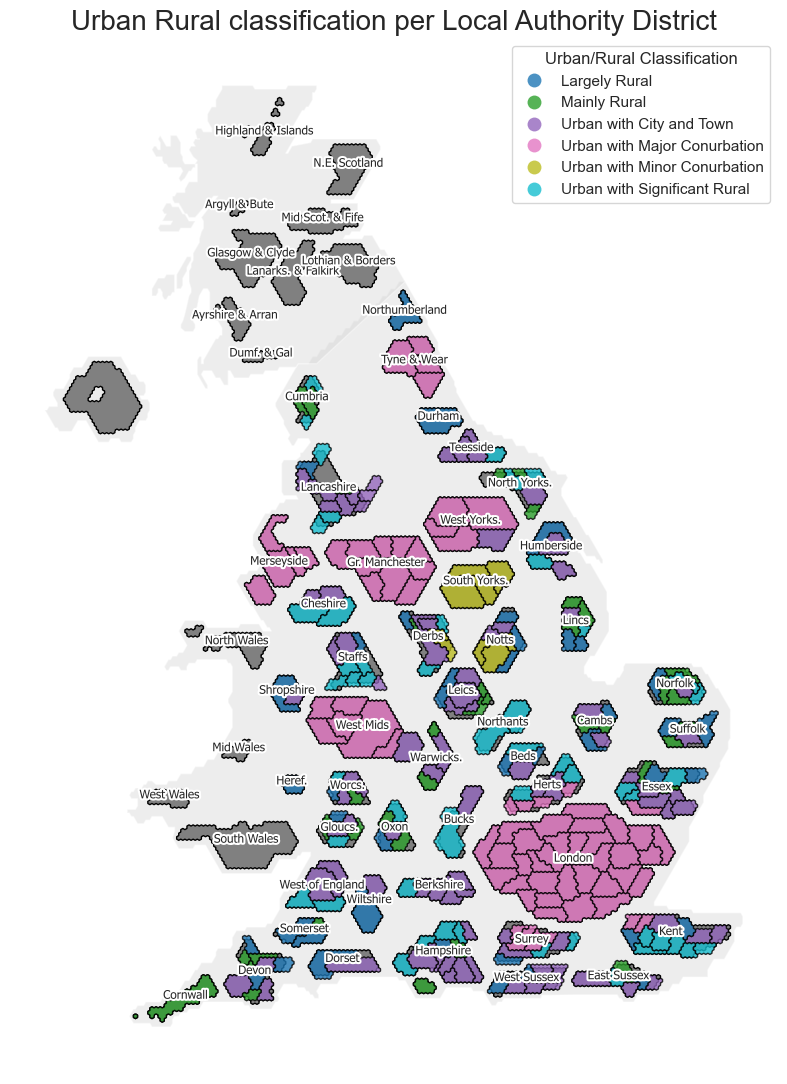

In [236]:
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
            color='grey',
            edgecolor='black')

UrbRu2.plot(column='Rural Urban Classification 2011 (6 fold)',
            legend=True,
            categorical=True,
            ax = ax,
            edgecolor='black',
            alpha=0.8,
            legend_kwds=dict(loc='upper right', title='Urban/Rural Classification'))

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)

plt.title('Urban Rural classification per Local Authority District', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=25)
#ax.legend(['Rural Urban Classification 2011 (6 fold)'], loc='upper right', fontsize=30)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Maps\Rural Urban Classification.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

Put reasoning for this here

###### Read in data

In [160]:
Main4 = pd.read_parquet("N:\Code Routing Behaviour\Clusters\Clust4Ukmaindata.parquet")

### Visualising Clusters by Local Authority Districts

In [161]:
Clust4 = Main4[['tid','origin','distance_straight_line','StopTime','num_of_turns','sinuosity','hour','weekday','clusters']].copy()

##### Extract orgin lats and lngs from dataset

In [162]:
%%time
Clust4[['lat','lng']] =Clust4['origin'].apply(lambda x: pd.Series(x))

CPU times: total: 2min 22s
Wall time: 2min 22s


In [163]:
%%time
Clust4.drop('origin', axis=1, inplace=True)
Clust4.to_csv("clust4plot.csv")

CPU times: total: 12.3 s
Wall time: 2min 23s


##### Read in origin data

In [82]:
%%time
Clupoint = gpd.read_file("N:\Code Routing Behaviour\Mapping\ClustPoint.geojson")

CPU times: total: 1min 57s
Wall time: 1min 58s


##### Join reprojected points to shapefile

In [83]:
%%time
CJoin = shape_file.sjoin(Clupoint, how='left').drop('index_right', axis=1)

CPU times: total: 8.28 s
Wall time: 8.28 s


                                                Clusters by Local Authority 

In [7]:
CJoinhex = Hex.merge(CJoin,on='LAD22CD', how='left')
CJoinhex.tail()

##### Find number of trips within clusters

In [85]:
Avg_clust = CJoinhex.groupby('LAD22CD')['clusters'].value_counts().rename('counts')
LAclust = Avg_clust.reset_index()

###### Compute percentage of cluster in LA District

In [8]:
# compute % of each cluster by LAD
LAclust["percent"] = LAclust.groupby('LAD22CD')['counts'].apply(lambda x: x/ x.sum() * 100)
LAclust=LAclust.reset_index()
LAclust.head()

                                      Highest represented clusters by LA District

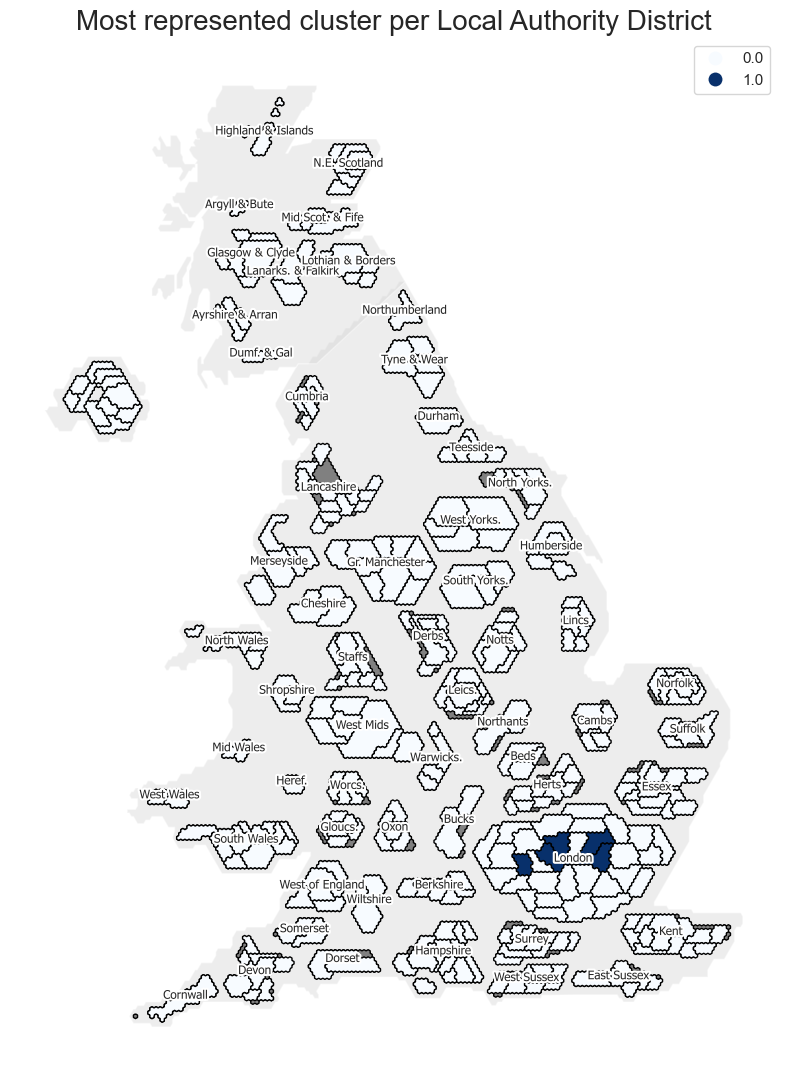

In [165]:
# Get most represented cluster by LAD and map
max_clusters = LAclust.loc[LAclust.groupby(['LAD22CD'])['percent'].idxmax()]
map_max_clusters = PJoinhex.merge(max_clusters, on='LAD22CD', how='left')
map_max_clusters1 = map_max_clusters.drop_duplicates(subset=['LAD22CD','clusters'])

#Plot figure
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
            color='grey',
            edgecolor='black')

map_max_clusters1.plot(column='clusters',
                      ax=ax,
                      categorical=True, 
                      cmap='Blues',
                      legend=True, 
                      edgecolor='black',
                      alpha=1)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)

plt.title('Most represented cluster per Local Authority District', fontsize=20) 
ax.tick_params(axis='both', which='major', labelsize=25)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Maps\Clustered_trips.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

In [65]:
cplot = map_max_clusters.reset_index().sort_values('percent', ascending=True)

In [ ]:
cplot.plot(kind ='barh', x='LAD22NM', y='clusters', cmap='RdBu_r' , figsize=(90,10))
plt.title('Average Travel Time per Local Authority District', fontsize=35)
plt.show()

                                 Percentage of Short trips (Cluster 0) per LA District

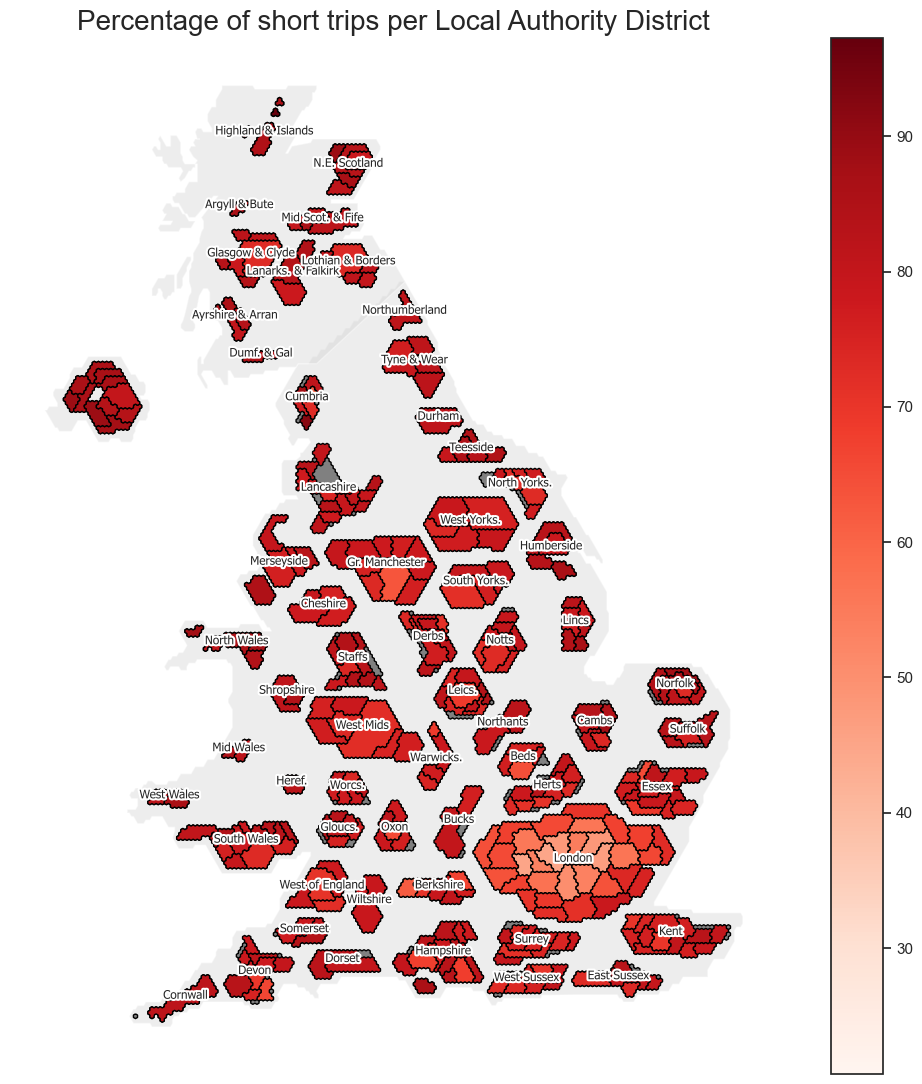

In [168]:
#Map % of short trips by LAD
map_clusters =  PJoinhex.merge(LAclust.loc[LAclust["clusters"]==0], on='LAD22CD', how='left')
map_clusters1 = map_clusters.drop_duplicates(subset=['LAD22CD','percent'])

#Plot figure
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
            color='grey',
            edgecolor='black')

map_clusters1.plot(column='percent',
                      ax=ax,
                      cmap='Reds',
                      legend=True, 
                      edgecolor='black',
                      alpha=1)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)


plt.title('Percentage of short trips per Local Authority District', fontsize=20),
ax.tick_params(axis='both', which='major', labelsize=25)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Maps\Short_trip_clustered.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

                                 Percentage of Mid trips (Cluster 1) per LA District

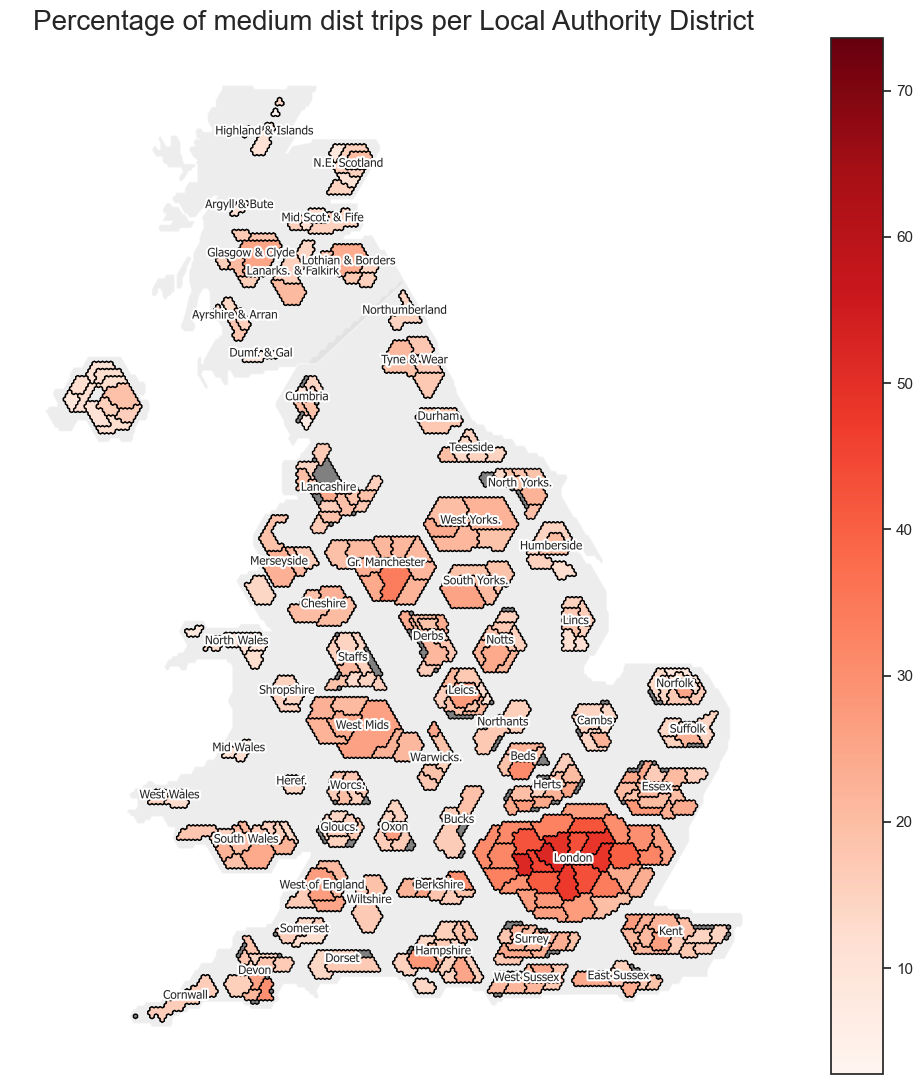

In [169]:
#Map % of medium-dist trips by LAD
map_clusters = PJoinhex.merge(LAclust.loc[LAclust["clusters"]==1], on='LAD22CD', how='left')
map_clusters2 = map_clusters.drop_duplicates(subset=['LAD22CD','percent'])


#Plot figure
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
            color='grey',
            edgecolor='black')

map_clusters2.plot(column='percent',
                      ax=ax,
                      cmap='Reds',
                      legend=True, 
                      edgecolor='black',
                      alpha=1)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)


plt.title('Percentage of medium dist trips per Local Authority District', fontsize=20),
ax.tick_params(axis='both', which='major', labelsize=25)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Maps\Mid_trip_clustered.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

                                 Percentage of Long trips (Cluster 2) per LA District

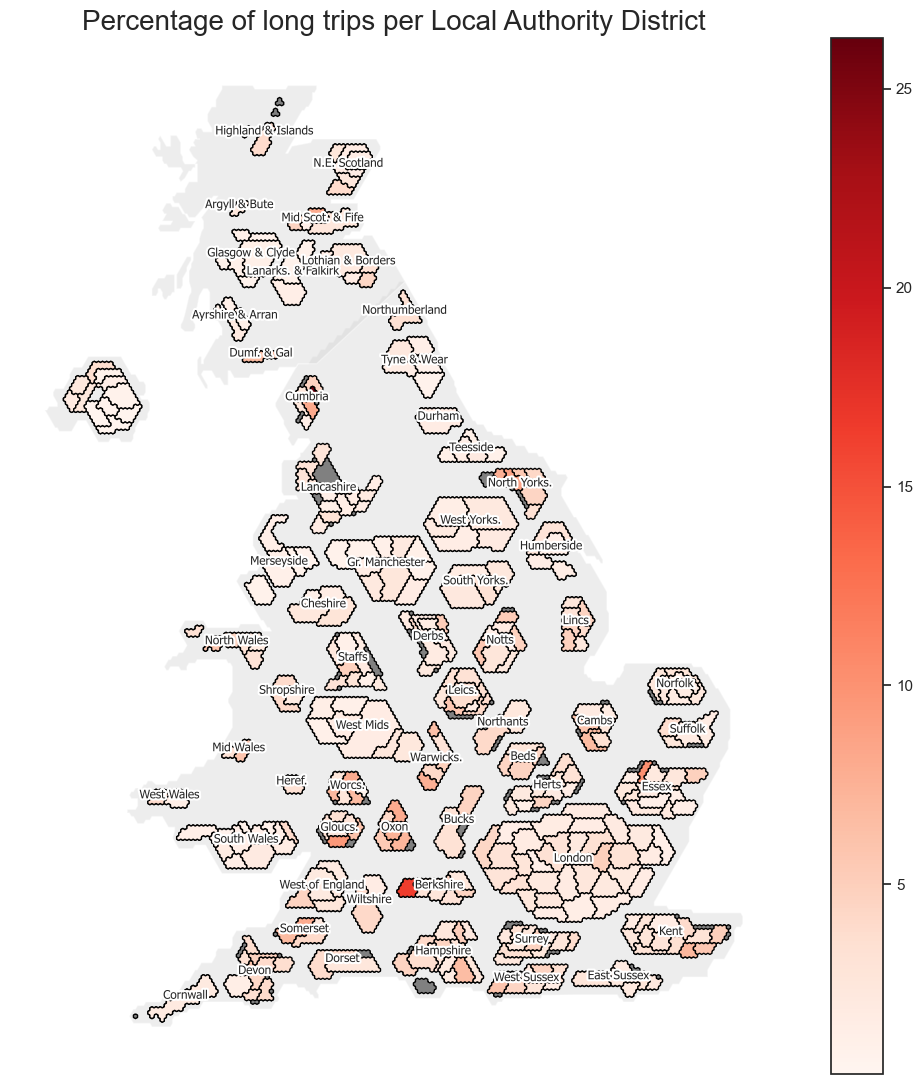

In [170]:
# Map % long trips by LAD
map_clusters = PJoinhex.merge(LAclust.loc[LAclust["clusters"]==2], on='LAD22CD', how='left')
map_clusters3 = map_clusters.drop_duplicates(subset=['LAD22CD','percent'])


#Plot figure
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
            color='grey',
            edgecolor='black')

map_clusters3.plot(column='percent',
                      ax=ax,
                      cmap='Reds',
                      legend=True, 
                      edgecolor='black',
                      alpha=1)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)


plt.title('Percentage of long trips per Local Authority District', fontsize=20),
ax.tick_params(axis='both', which='major', labelsize=25)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Maps\Long_trip_clustered.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

                                 Percentage of Round trips (Cluster 3) per LA District

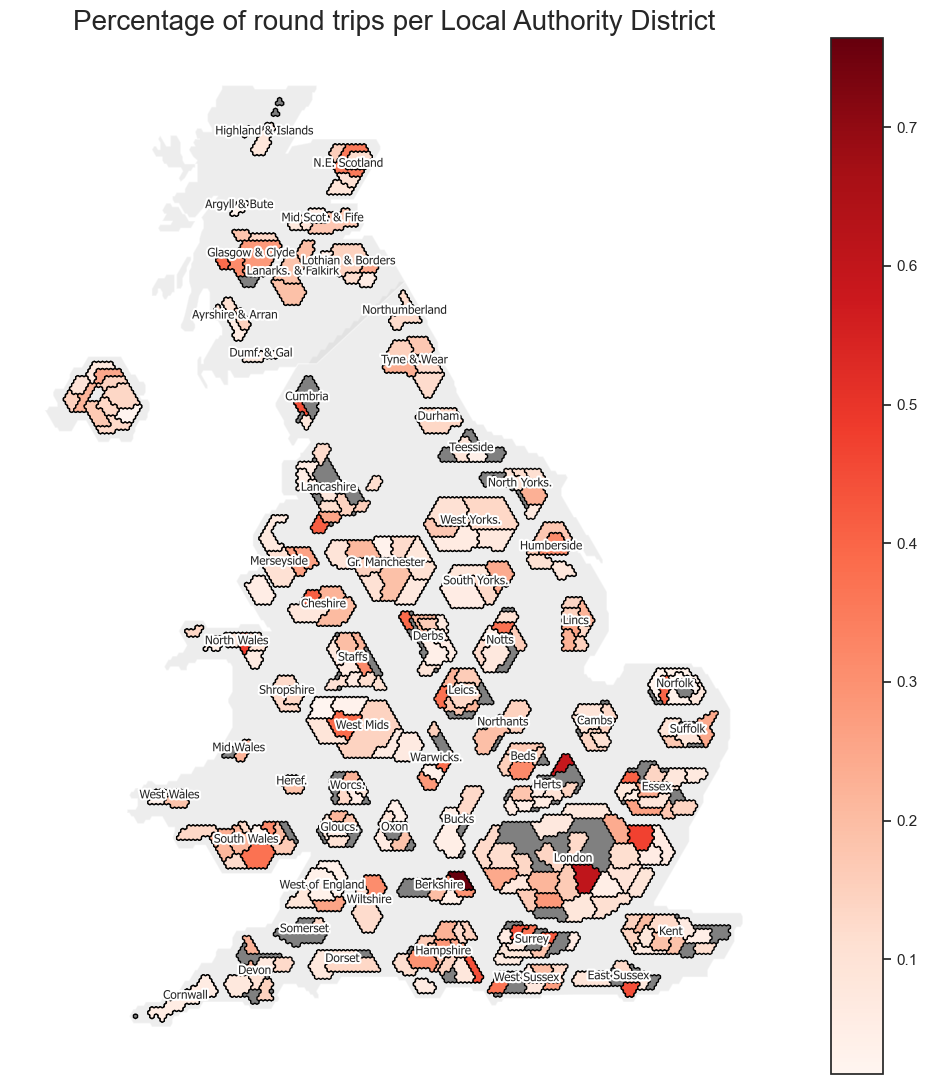

In [171]:
#Map % round trips by LAD (not reliable as some round trips have been removed in previous steps)
map_clusters = PJoinhex.merge(LAclust.loc[LAclust["clusters"]==3], on='LAD22CD', how='left')
map_clusters4 = map_clusters.drop_duplicates(subset=['LAD22CD','percent'])

#Plot figure
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
            color='grey',
            edgecolor='black')

map_clusters4.plot(column='percent',
                      ax=ax,
                      cmap='Reds',
                      legend=True, 
                      edgecolor='black',
                      alpha=1)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)


plt.title('Percentage of round trips per Local Authority District', fontsize=20),
ax.tick_params(axis='both', which='major', labelsize=25)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Maps\Round_trip_clustered.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

                                        Visulaising Cluster 0- Re_Clustered

In [104]:
Main05 = pd.read_parquet("N:\Code Routing Behaviour\Clusters\Cluster0_L2_5clust.parquet")

In [42]:
L2_5clust = Main05[['tid','origin','distance_straight_line','StopTime','num_of_turns','sinuosity','hour','weekday','clusters','Cluster_L2']].copy()

In [56]:
cl5mean= L2_5clust.set_index('tid').drop(['lat','lng'], axis=1).groupby('Cluster_L2').mean()
cl5mean

distance_straight_line   StopTime  num_of_turns  sinuosity  \
Cluster_L2                                                               
0                         3.965279   1.141974      6.836474   1.345232   
1                         5.177984   2.648828     13.246878   2.681068   
2                        15.893092  16.418198     14.551763   1.388801   
3                         6.774498   3.274054     17.561960   1.452172   
4                        29.572492   4.038962     12.903275   1.334316   

            clusters  
Cluster_L2            
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0

##### Extract orgin lats and lngs from dataset

In [44]:
%%time
L2_5clust[['lat','lng']] = L2_5clust['origin'].apply(lambda x: pd.Series(x))

CPU times: total: 1min 44s
Wall time: 1min 44s


In [45]:
%%time
L2_5clust.drop('origin', axis=1, inplace=True)
L2_5clust.to_csv("L2_5clust.csv")

CPU times: total: 9.39 s
Wall time: 1min 43s


##### Read in origin data

In [95]:
%%time
L2_clust = gpd.read_file("N:\Code Routing Behaviour\Mapping\L2_5clust.geojson")

CPU times: total: 1min 35s
Wall time: 1min 36s


##### Join reprojected points to shapefile

In [96]:
%%time
L2Join = shape_file.sjoin(L2_clust, how='left').drop('index_right', axis=1)

CPU times: total: 10.3 s
Wall time: 10.3 s


                                                Clusters by Local Authority 

In [9]:
L2Joinhex = Hex.merge(L2Join, on='LAD22CD', how='left')
L2Joinhex.tail()

##### Find number of trips within clusters

In [98]:
LAvg_clust = L2Joinhex.groupby('LAD22CD')['Cluster_L2'].value_counts().rename('counts')
LA2clust = LAvg_clust.reset_index()

###### Compute percentage of cluster in LA District

In [99]:
# compute % of each cluster by LAD
LA2clust["percent"] = LA2clust.groupby('LAD22CD')['counts'].apply(lambda x: x/ x.sum() * 100)
LA2clust=LA2clust.reset_index()

In [100]:
max_reclusters = LA2clust.loc[LA2clust.groupby(['LAD22CD'])['percent'].idxmax()]
max_reclusters['Cluster_L2'] = max_reclusters['Cluster_L2'].apply(lambda x: int(x))
max_reclusters.head()

index    LAD22CD  Cluster_L2  counts    percent
0       0  E06000001           0    1389  55.316607
5       5  E06000002           0    1014  49.463415
10     10  E06000003           0     889  55.114693
15     15  E06000004           0    1859  51.212121
20     20  E06000005           0     942  47.672065

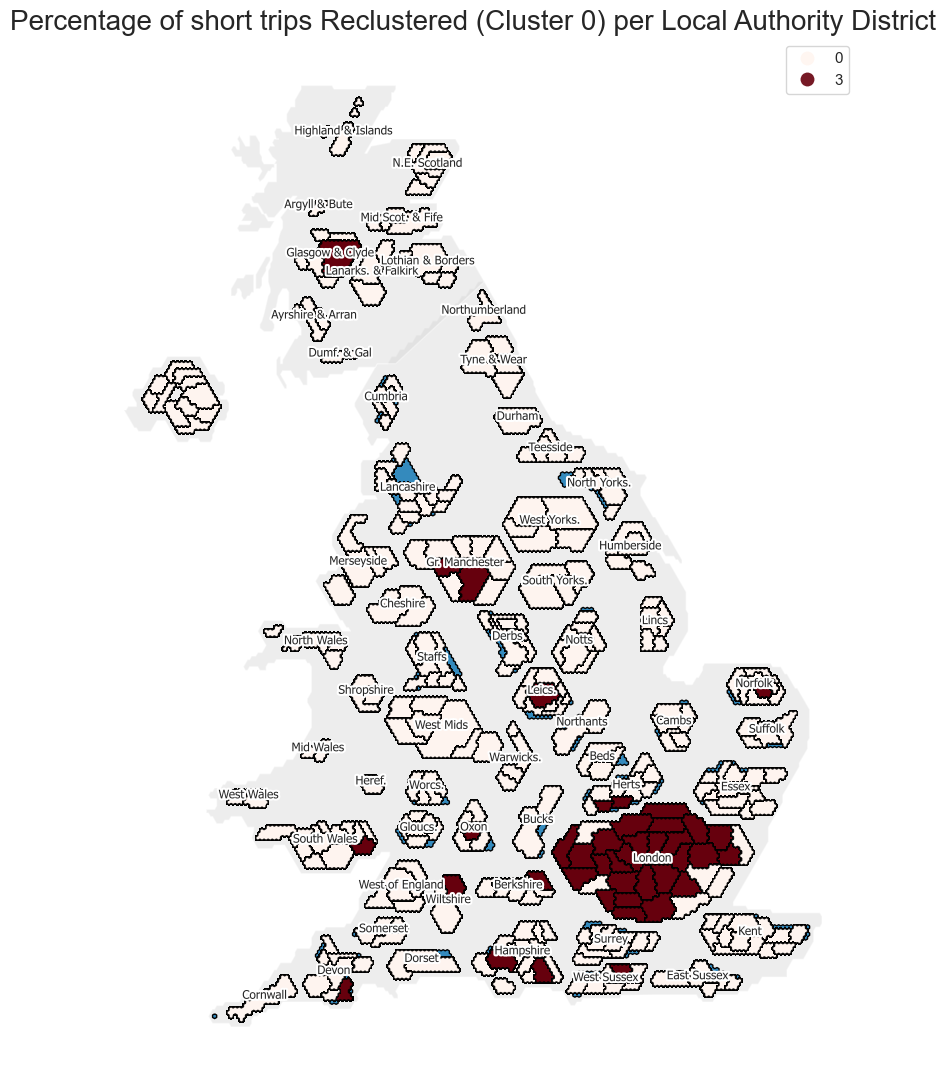

In [101]:
#Map % round trips by LAD (not reliable as some round trips have been removed in previous steps)
max_reclusters = LA2clust.loc[LA2clust.groupby(['LAD22CD'])['percent'].idxmax()]
reclusted = PJoinhex.merge(max_reclusters, on='LAD22CD', how='left')

#Plot figure
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
            edgecolor='black')

reclusted.plot(column='Cluster_L2',
                      ax=ax,
                      cmap='Reds',
                      legend=True,
                      edgecolor='black',
                      alpha=0.9)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)


plt.title('Percentage of short trips Reclustered (Cluster 0) per Local Authority District', fontsize=20),
ax.tick_params(axis='both', which='major', labelsize=25)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Clustering\Maps\Re_clustered\Re_clustered_Domtrips_LA.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

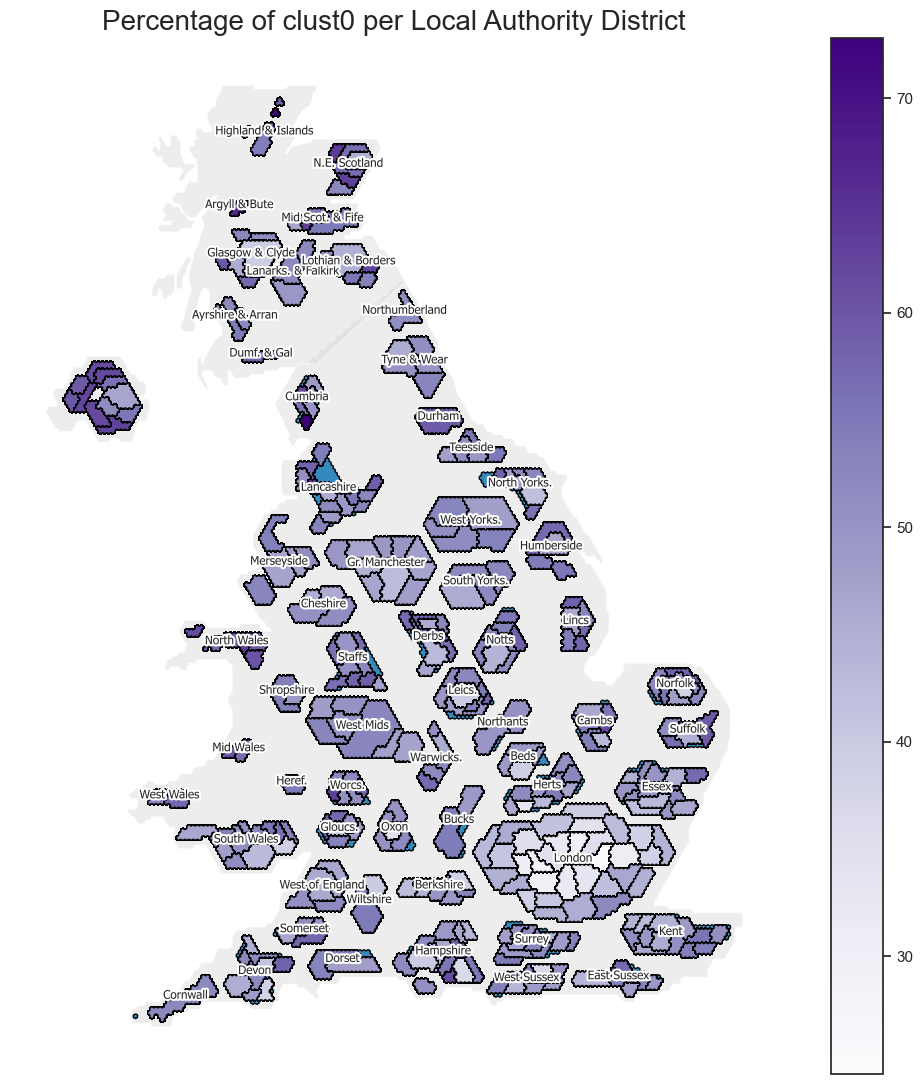

In [103]:
#Map % round trips by LAD (not reliable as some round trips have been removed in previous steps)
map_reclusters = PJoinhex.merge(LA2clust.loc[LA2clust["Cluster_L2"]=='0'], on='LAD22CD', how='left')

#Plot figure
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
            edgecolor='black')

map_reclusters.plot(column='percent',
                      ax=ax,
                      cmap='Purples',
                      legend=True, 
                      edgecolor='black',
                      alpha=0.9)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)


plt.title('Percentage of clust0 per Local Authority District', fontsize=20),
ax.tick_params(axis='both', which='major', labelsize=25)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Clustering\Maps\Re_clustered\Map_Direct_Short_Clust0.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

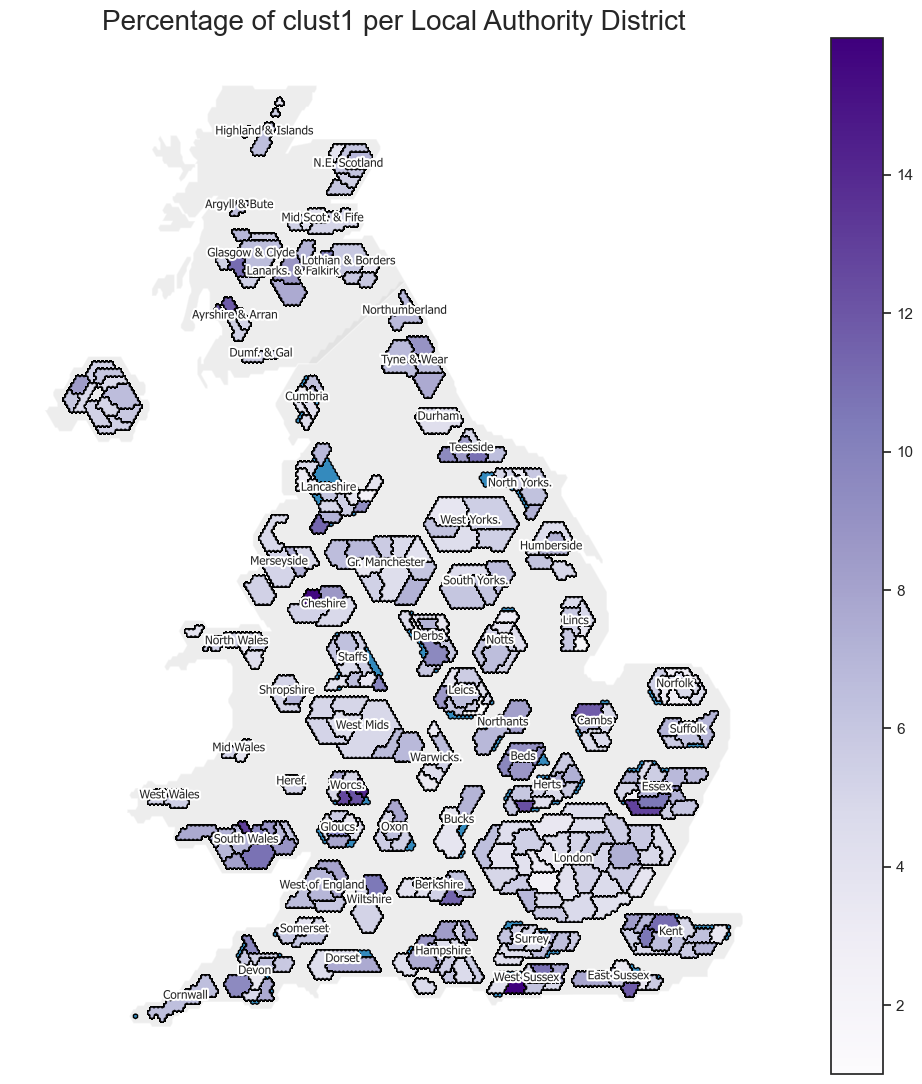

In [104]:
#Map % round trips by LAD (not reliable as some round trips have been removed in previous steps)
map_reclusters = PJoinhex.merge(LA2clust.loc[LA2clust["Cluster_L2"]=='1'], on='LAD22CD', how='left')

#Plot figure
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
            edgecolor='black')

map_reclusters.plot(column='percent',
                      ax=ax,
                      cmap='Purples',
                      legend=True, 
                      edgecolor='black',
                      alpha=0.9)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)


plt.title('Percentage of clust1 per Local Authority District', fontsize=20),
ax.tick_params(axis='both', which='major', labelsize=25)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Clustering\Maps\Re_clustered\Cluster2nd_L2.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

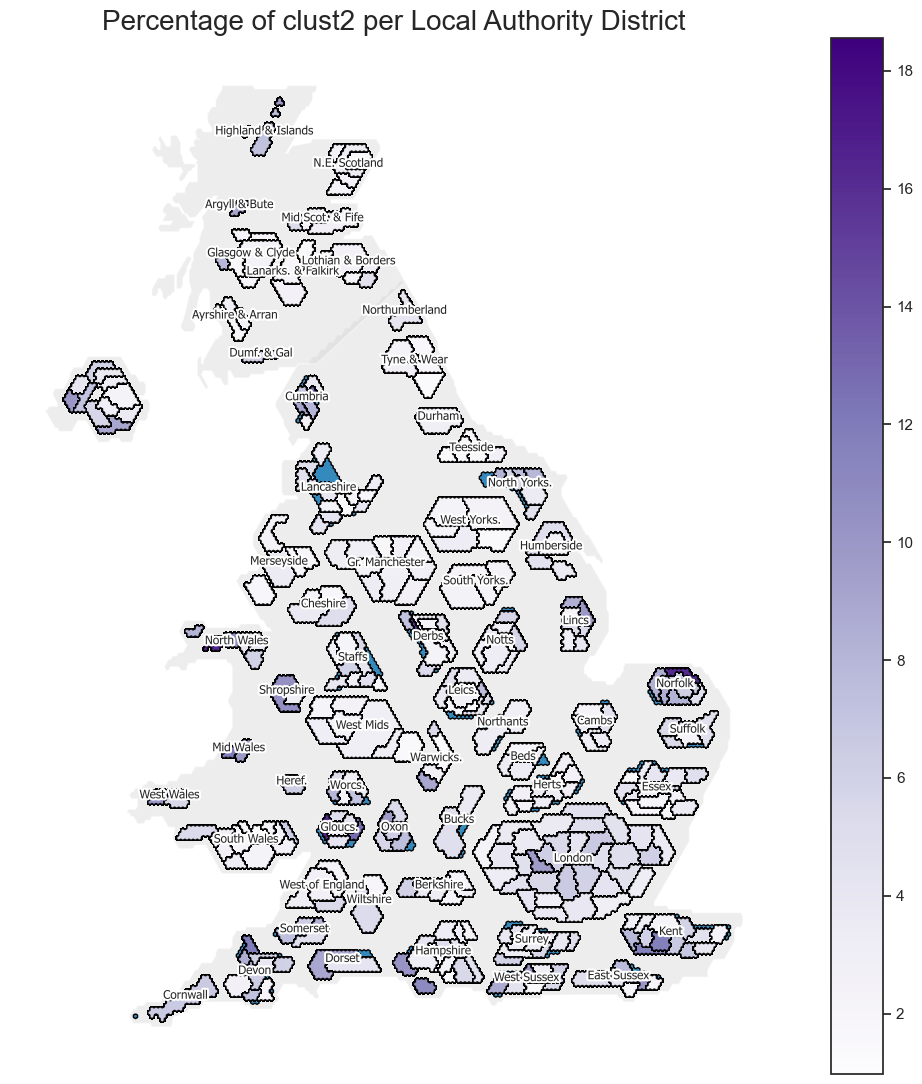

In [105]:
#Map % round trips by LAD (not reliable as some round trips have been removed in previous steps)
map_reclusters = PJoinhex.merge(LA2clust.loc[LA2clust["Cluster_L2"]=='2'], on='LAD22CD', how='left')

#Plot figure
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
            edgecolor='black')

map_reclusters.plot(column='percent',
                      ax=ax,
                      cmap='Purples',
                      legend=True, 
                      edgecolor='black',
                      alpha=0.9)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)


plt.title('Percentage of clust2 per Local Authority District', fontsize=20),
ax.tick_params(axis='both', which='major', labelsize=25)
seaborn.set_theme(style='white')
ax.axis('off')
plt.savefig(r"N:\Output\Full Dataset\Clustering\Maps\Re_clustered\Cluster3_L2.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

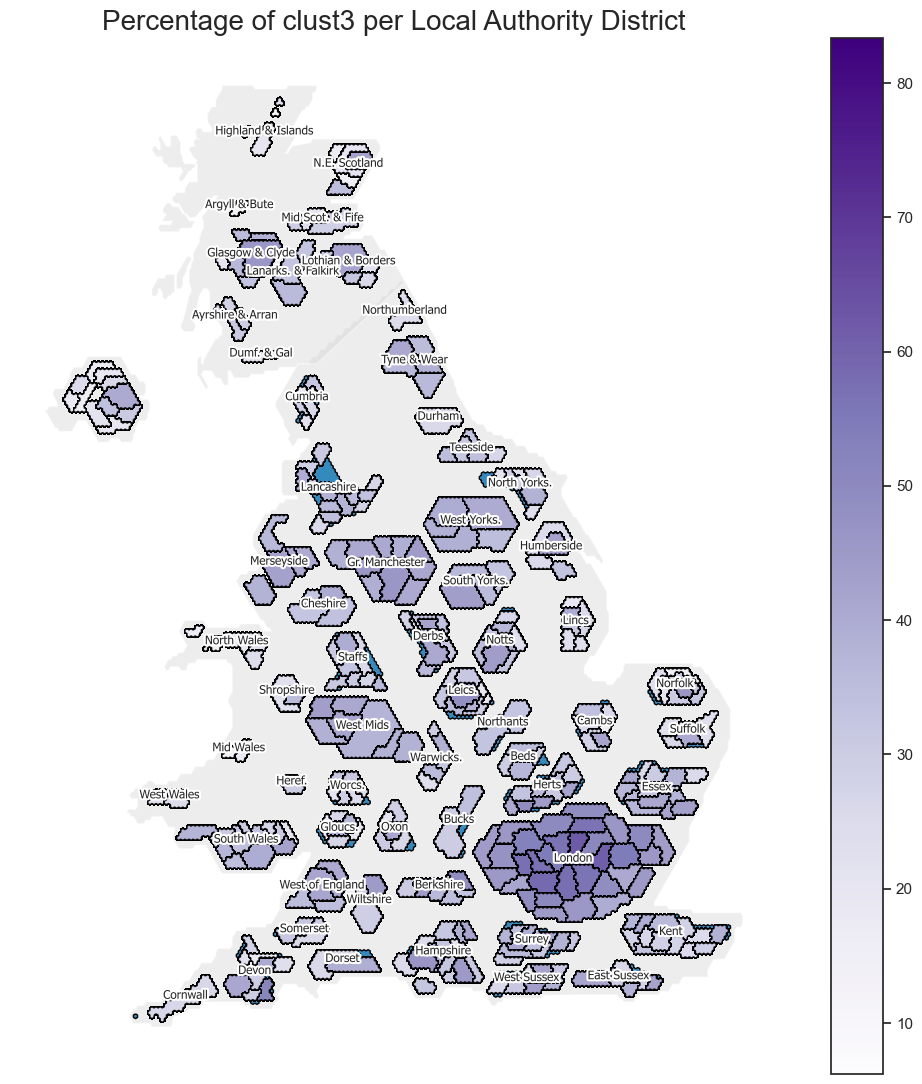

In [107]:
#Map % round trips by LAD (not reliable as some round trips have been removed in previous steps)
map_reclusters = PJoinhex.merge(LA2clust.loc[LA2clust["Cluster_L2"]=='3'], on='LAD22CD', how='left')

#Plot figure
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
            edgecolor='black')

map_reclusters.plot(column='percent',
                      ax=ax,
                      cmap='Purples',
                      legend=True, 
                      edgecolor='black',
                      alpha=0.9)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)


plt.title('Percentage of clust3 per Local Authority District', fontsize=20),
ax.tick_params(axis='both', which='major', labelsize=25)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Clustering\Maps\Re_clustered\Cluster4_L2.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

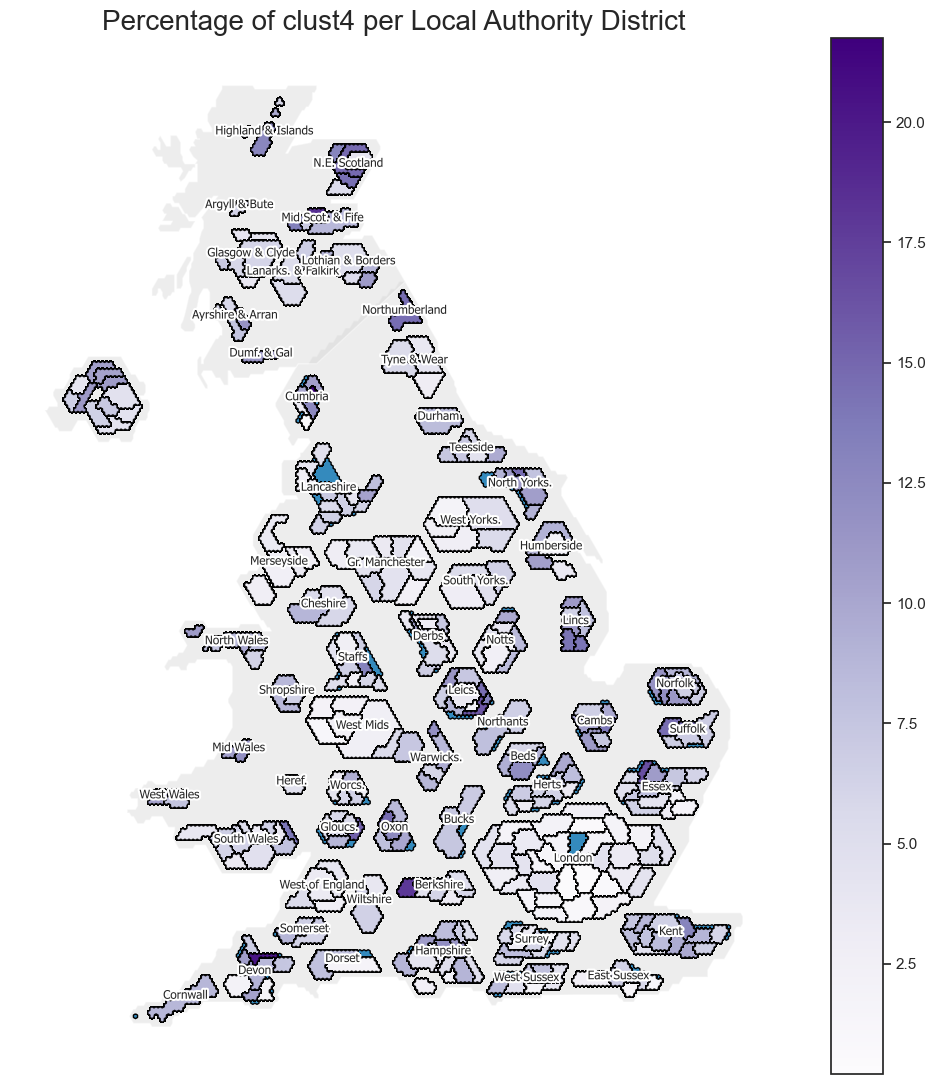

In [106]:
#Map % round trips by LAD (not reliable as some round trips have been removed in previous steps)
map_reclusters = PJoinhex.merge(LA2clust.loc[LA2clust["Cluster_L2"]=='4'], on='LAD22CD', how='left')

#Plot figure
fig, ax = plt.subplots(figsize=(11,11))

hex_backlayer.plot(ax = ax,
                  color='lightgrey',
                  alpha=0.4)
hex_G2.plot(ax=ax,
            edgecolor='black')

map_reclusters.plot(column='percent',
                      ax=ax,
                      cmap='Purples',
                      legend=True, 
                      edgecolor='black',
                      alpha=0.9)

hex_G2.apply(lambda x: ax.annotate(text=x['Group-labe'], xy=x.geometry.centroid.coords[0], ha='center', fontfamily='Tahoma', fontsize=8.5, path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]), axis=1)


plt.title('Percentage of clust4 per Local Authority District', fontsize=20),
ax.tick_params(axis='both', which='major', labelsize=25)
seaborn.set_theme(style='white')
ax.axis('off')

plt.savefig(r"N:\Output\Full Dataset\Clustering\Maps\Re_clustered\Cluster5_L2.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

##### Distance travelled by LA over weekday

In [14]:
heat = PJoin.copy()

In [15]:
disT = heat.groupby(by = ['LAD22NM', 'hour'])['distance_straight_line'].mean()
Dist = disT.reset_index()

In [20]:
mask = (Dist['hour'] > '05:00') & (Dist['hour'] < '21:00')

In [59]:
dfm= heat[mask]

In [45]:
df['weekday'] = pd.Categorical(df['weekday'], 
                                categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)

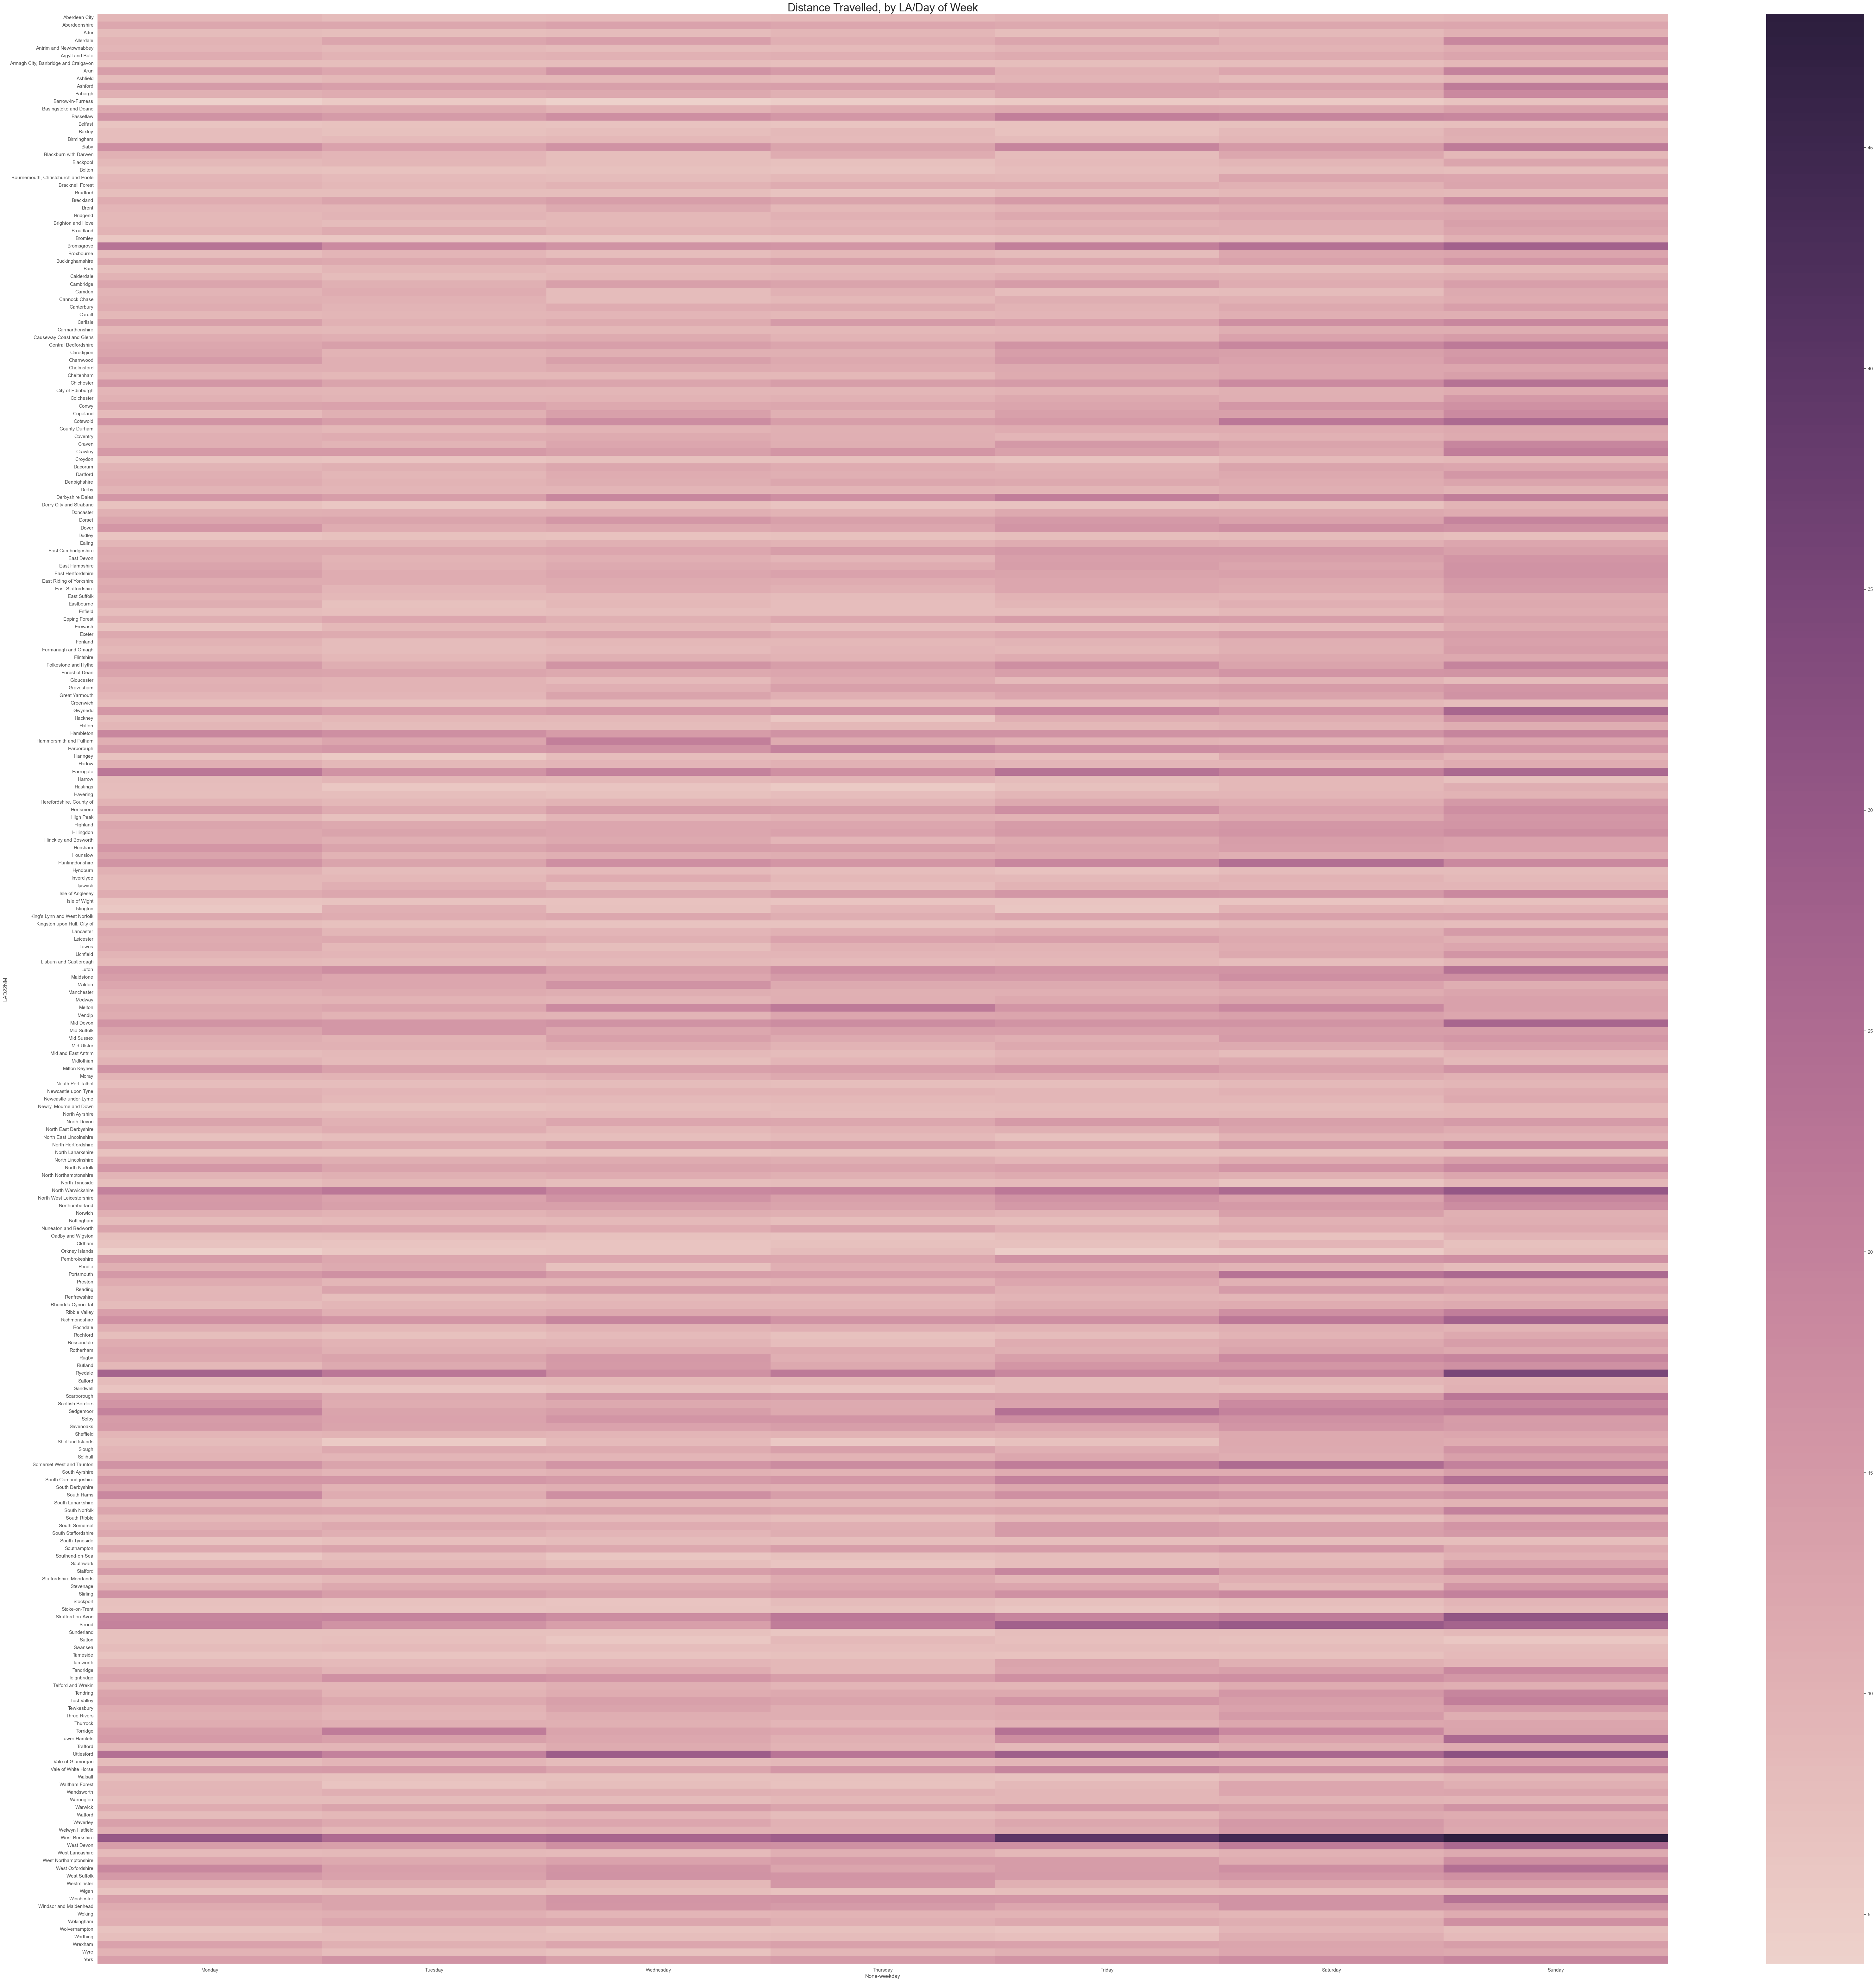

In [55]:
fig, ax = plt.subplots(1, figsize=(80,80))


sns.heatmap(pd.pivot_table(df, index=["LAD22NM"],columns=["weekday"],values=["distance_straight_line"]), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels = (['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']),
            )  

plt.title('Distance Travelled, by LA/Day of Week', fontsize=25)
plt.show()